In [8]:
from functools import partial
from collections.abc import Iterable
from pathlib import Path
from utils import bayesian_stats_course_tools
import astropy
import scipy
import dynesty

import numpy as np

## Application: is the Universe flat?

As the Universe expands, photons lose energy: space expands, which causes the wave length of photons to increase.

Objects further away thus have their spectrum shifted to longer wave lengths: the cosmological redshift.

If we can measure the distance and redshift of an object, we can learn about how the Universe expands, from which we can infer how much dark energy there is, if the Universe is spatially flat, etc.



Here we want to find out if the Universe is better described by a model that assumes that the Universe is spatially flat or one that allows curvature.

Recall that we can use the Bayes' ratio to compare the probability of two models $M_1$ and $M_2$:
$$
    R = \frac{p(d | M_1)}{p(d | M_2)}
$$
With nested sampling we can compute the evidences $Z_1 = p(d | M_1)$ and $Z_2 = p(d | M_2)$.

One way to do this to look at Type Ia super novae: due to the astrophysical processes behind them, we know how bright they are intrinsically. This allows us to estimate the distance to a Type Ia super nova. This is a special property, usually we do not know how far objects are away!



Given a redshift $z$ and a cosmological model, we can compute the luminosity distance $d_L(z)$:
$$
d_L(z) = (1+z) c \int_0^z \frac{d z'}{H(z')}\,,
$$
where $c$ is the speed of light and
$$
H(z)^2 = H_0^2\left(\Omega_m(1+z)^3 + \Omega_\Lambda + (1-\Omega_m-\Omega_\Lambda)(1+z)^{-2}\right) \,.
$$
Here $H_0$ is the Hubble constant (the expansion rate of the Universe today), $\Omega_m$ the amount of matter in the Universe, and $\Omega_\Lambda$ the amount of dark energy.



For historical reasons, units in astronomy are weird. Instead of using the luminosity distance as the quantity to compare with data, we use the distance modulus $\mu(z)$:
$$
\mu(z) = 5\log_{10}\left(\frac{d_L(z)}{10\,\mathrm{pc}}\right) + M\,,
$$
where $M$ is a calibration parameter that we will marginalise over.


For the data we use the Pantheon sample (Brout+2022, https://arxiv.org/abs/2202.04077). This includes about 1500 Type Ia super novae and is the state-of-the-art data set fort this observation. We simplify our analysis a little bit here but the full setup is not that much more complicated.

The data are observations of the distance moduli $\hat{\mu_i}$ at redshfits $z_i$. The data are correlated, so we need a multivariate Gaussian likelihood:
$$
\vec{\hat{\mu}} \sim N(\vec{\mu}(\vec z), \Sigma)\,,
$$
where the $\vec{\mu}(\vec z)$ is the predicted distance modulus from the last slide.

In [9]:
from utils.likelihood import PantheonSH0ESLikelihood
data_path = Path("data")
# This holds the data and takes care of the modelling
pantheon_sh0es = PantheonSH0ESLikelihood(
    data_file_name=data_path / "pantheon_sh0es.npz",
)

# Pull out data for our simplified analysis
z_data = pantheon_sh0es.z_CMB
data = pantheon_sh0es.magnitude_data
data_error_bar = pantheon_sh0es.magnitude_data_error
inv_covariance = np.linalg.inv(pantheon_sh0es.covariance_no_calibrator)

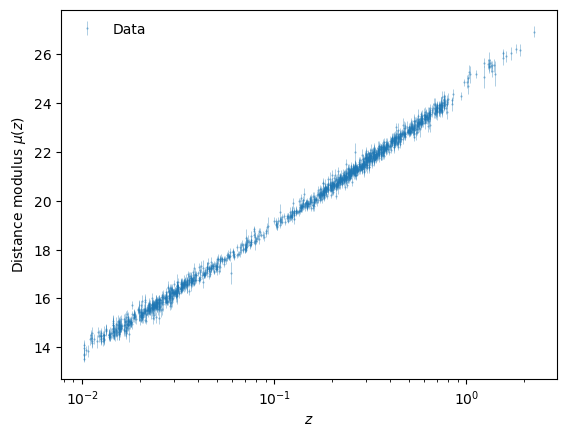

In [10]:
# And plot it
fig, ax = bayesian_stats_course_tools.analyse.plot_data(
    x=z_data, y=data, y_err=data_error_bar, axis_labels=["$z$", r"Distance modulus $\mu(z)$"],
    linestyle="none", marker=".", markersize=1, alpha=0.5, elinewidth=0.5,
)
ax.set_xscale("log")

Implement the physics model. We use the `astropy` library to compute the luminosity distance.

In [11]:
def compute_distance_modulus(cosmology, z):
    luminosity_distance = cosmology.luminosity_distance(z)
    luminosity_distance = (luminosity_distance/astropy.units.Mpc).value

    mu = 5.0*np.log10(luminosity_distance*1e6/10)
    return mu

def LCDM_distance_modulus_model(theta, z):
    H_0, Omega_m, Omega_de, M = theta
    cosmology = astropy.cosmology.LambdaCDM(H0=H_0, Om0=Omega_m, Ode0=Omega_de)

    prediction = compute_distance_modulus(cosmology, z)
    prediction += M

    return prediction

We also look at another model where we assume the Universe is spatially flat. This is the case when $\Omega_m + \Omega_\Lambda = 1$. We then want to find out if the data prefer the general model or the flat model.

In [12]:
def flat_LCDM_distance_modulus_model(theta, z):
    H_0, Omega_m, M = theta
    cosmology = astropy.cosmology.FlatLambdaCDM(H0=H_0, Om0=Omega_m)

    prediction = compute_distance_modulus(cosmology, z)
    prediction += M

    return prediction

In [13]:
# From the SH0ES analysis Riess+2022 (https://arxiv.org/abs/2112.04510)
H_0_prior = scipy.stats.norm(loc=73.04, scale=1.04)

# scipy.stats.uniform defines the interval as [loc, loc+scale]
Omega_m_prior = scipy.stats.uniform(loc=0.1, scale=0.8)
Omega_de_prior = scipy.stats.uniform(loc=0.1, scale=0.8)
M_prior = scipy.stats.uniform(loc=-20, scale=2)

Finally the multivariate Gaussian likelihood.

In [14]:
def make_likelihood(model):
    def log_likelihood(theta):
        r = data - model(theta, z=z_data)
        return -0.5 * r @ inv_covariance @ r
    
    L = np.linalg.cholesky(pantheon_sh0es.covariance_no_calibrator)

    def sample_from_likelihood(theta):
        # scipy.stats.multivariate_normal is VERY slow for the 
        # large covariance we have, so we sample it ourselves
        mu = model(theta, z=z_data)
        sample = L @ np.random.normal(size=mu.size) + mu
        return sample
    
    return log_likelihood, sample_from_likelihood

In [15]:
log_likelihood_LCDM, sample_from_likelihood_LCDM = make_likelihood(LCDM_distance_modulus_model)

def log_prior_lcdm(theta):
    H_0, Omega_m, Omega_de, M = theta
    return H_0_prior.logpdf(H_0) + Omega_m_prior.logpdf(Omega_m) + Omega_de_prior.logpdf(Omega_de) + M_prior.logpdf(M)

def log_posterior_lcdm(theta):
    p = log_prior_lcdm(theta)
    if not np.isfinite(p):
        return -np.inf
    return log_likelihood_LCDM(theta) + p

theta_init_lcdm = np.array([80.0, 0.2, 0.5, -19.5])

MAP_result = scipy.optimize.minimize(
    fun=lambda theta: -log_posterior_lcdm(theta),
    x0=theta_init_lcdm,
    method="Nelder-Mead",
)
theta_MAP_lcdm = MAP_result.x

In [9]:
log_likelihood_flat_LCDM, sample_from_likelihood_flat_LCDM = make_likelihood(flat_LCDM_distance_modulus_model)

def log_prior_flat_lcdm(theta):
    H_0, Omega_m, M = theta
    return H_0_prior.logpdf(H_0) + Omega_m_prior.logpdf(Omega_m) + M_prior.logpdf(M)

def log_posterior_flat_lcdm(theta):
    p = log_prior_flat_lcdm(theta)
    if not np.isfinite(p):
        return -np.inf
    return log_likelihood_flat_LCDM(theta) + p

theta_init_flat_lcdm = np.array([80.0, 0.2, -19.5])

MAP_result = scipy.optimize.minimize(
    fun=lambda theta: -log_posterior_flat_lcdm(theta),
    x0=theta_init_flat_lcdm,
    method="Nelder-Mead",
)
theta_MAP_flat_lcdm = MAP_result.x


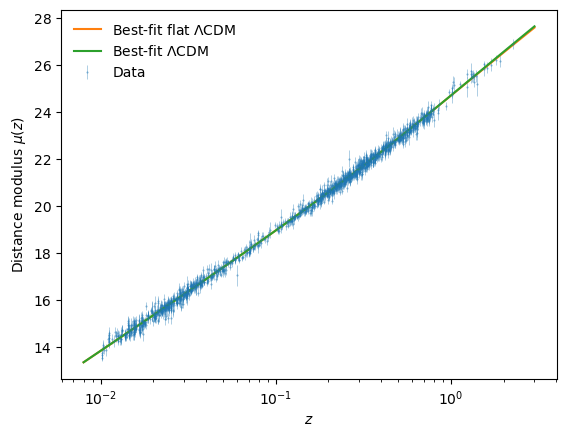

In [10]:
z_fine = np.geomspace(0.008, 3, 100)

fig, ax = bayesian_stats_course_tools.analyse.plot_data(
    x=z_data, y=data, y_err=data_error_bar, axis_labels=["$z$", r"Distance modulus $\mu(z)$"],
    linestyle="none", marker=".", markersize=1, alpha=0.5, elinewidth=0.5,
    models=[
        dict(x=z_fine, y=flat_LCDM_distance_modulus_model(theta=theta_MAP_flat_lcdm, z=z_fine), style={"label": r"Best-fit flat $\Lambda$CDM"}),
        dict(x=z_fine, y=LCDM_distance_modulus_model(theta=theta_MAP_lcdm, z=z_fine), style={"label": r"Best-fit $\Lambda$CDM"})
    ]
)
ax.set_xscale("log")

Both models fit the data very well. Can we still say which one we should prefer?

Recall that we can use the Bayes' ratio to compare the probability of two models $M_1$ and $M_2$:
$$
    R = \frac{p(d | M_1)}{p(d | M_2)}
$$

With nested sampling we can compute the evidences $Z_1 = p(d | M_1)$ and $Z_2 = p(d | M_2)$.

Set up the priors for `dynesty`:

In [11]:
def prior_transform_flat_LCDM(u):
    x = np.array([
        H_0_prior.ppf(u[0]),
        Omega_m_prior.ppf(u[1]),
        M_prior.ppf(u[2])
    ])

    return x

def prior_transform_LCDM(u):
    x = np.array([
        H_0_prior.ppf(u[0]),
        Omega_m_prior.ppf(u[1]),
        Omega_de_prior.ppf(u[2]),
        M_prior.ppf(u[3])
    ])

    return x

And run `dynesty` to get estimates of the evidence. We get samples from the posterior as well during this.

In [22]:
sampler_flat_lcdm = dynesty.NestedSampler(
    loglikelihood=log_likelihood_flat_LCDM,
    prior_transform=prior_transform_flat_LCDM,
    ndim=3,
    nlive=100,
)
sampler_flat_lcdm.run_nested(print_progress=True)

sampler_flat_lcdm.results.summary()

986it [00:14, 48.95it/s, bound: 28 | nc: 4 | ncall: 7680 | eff(%): 12.839 | loglstar:   -inf < -720.993 <    inf | logz: -729.311 +/-  0.269 | dlogz:  0.234 >  0.109]     /Users/dschoess/Applications/miniconda3/envs/stats_course/lib/python3.13/site-packages/dynesty/bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or rwalk) or alternatively disable bootstrap (bootstrap=0)
  warnings.warn(
1057it [00:20, 52.14it/s, +100 | bound: 46 | nc: 1 | ncall: 10409 | eff(%): 11.223 | loglstar:   -inf < -720.845 <    inf | logz: -729.096 +/-  0.269 | dlogz:  0.001 >  0.109]

Summary
nlive: 100
niter: 1057
ncall: 10309
eff(%): 11.223
logz: -729.096 +/-  0.321


In [23]:
sampler_lcdm = dynesty.NestedSampler(
    loglikelihood=log_likelihood_LCDM,
    prior_transform=prior_transform_LCDM,
    ndim=4,
    nlive=100,
)
sampler_lcdm.run_nested(print_progress=True)

sampler_lcdm.results.summary()

1154it [00:29, 38.47it/s, +100 | bound: 74 | nc: 1 | ncall: 14631 | eff(%):  8.630 | loglstar:   -inf < -720.744 <    inf | logz: -729.961 +/-  0.278 | dlogz:  0.001 >  0.109]

Summary
nlive: 100
niter: 1154
ncall: 14531
eff(%):  8.630
logz: -729.961 +/-  0.329


To get an estimate of the uncertainty of the Bayes' ratio, we use a tool from `dynesty` to resample our runs to get a set of evidence estimates.

In [24]:
log_R = []
for i in range(100):
    log_z_flat_lcdm = dynesty.utils.jitter_run(sampler_flat_lcdm.results).logz[-1]
    log_z_lcdm = dynesty.utils.jitter_run(sampler_lcdm.results).logz[-1]
    log_R.append(log_z_flat_lcdm - log_z_lcdm)

log_R = np.array(log_R)

R_mean = np.mean(np.exp(log_R))
R_std = np.std(np.exp(log_R))
print(f"Bayes' ratio: {R_mean:.2f} ± {R_std:.2f}")

Bayes' ratio: 2.66 ± 1.01


# Comment

For some reason we are getting a very different value for the ratio compared to what he got in his code

# Things to do
## Mentioned specifically in lecture
- Prior predictive checks
- (adjust model -> probably not for us as he mentioned this is more for people with knowledge in astrology)
- Full posterior analysis
    - How do they look
- Perform model checks
    - Do model & likelihood actually predict the data
    - Are the fits good?

## Extracted from other parts of lecture
- Compare model fit
    - MAP, model predictive distr, posterior predictive distr (for example check lin_fits exercise solutions)
- Model checking
    - Chi-square
    - Posterior predictive distr checks (ppd_model_check function in the script)
- Model comparison
    - DIC, WAIC, cross-validation


## Write paper